<a href="https://colab.research.google.com/github/amurkhon/AviaticketsPrediction/blob/main/prediction_aviatickets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#standard libraries
import pandas as pd
import numpy as np

#visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv("/content/train_data.csv")
train_data.head(10)

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712
5,6,Air_India,AI-636,Delhi,Afternoon,one,Morning,Chennai,Business,20.42,5,45257
6,7,Vistara,UK-834,Chennai,Evening,one,Morning,Mumbai,Economy,18.42,20,5054
7,8,Air_India,AI-505,Bangalore,Morning,zero,Afternoon,Delhi,Business,2.58,30,32923
8,9,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Hyderabad,Economy,15.92,12,11383
9,10,Air_India,AI-538,Chennai,Night,one,Afternoon,Mumbai,Economy,16.50,18,4357


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


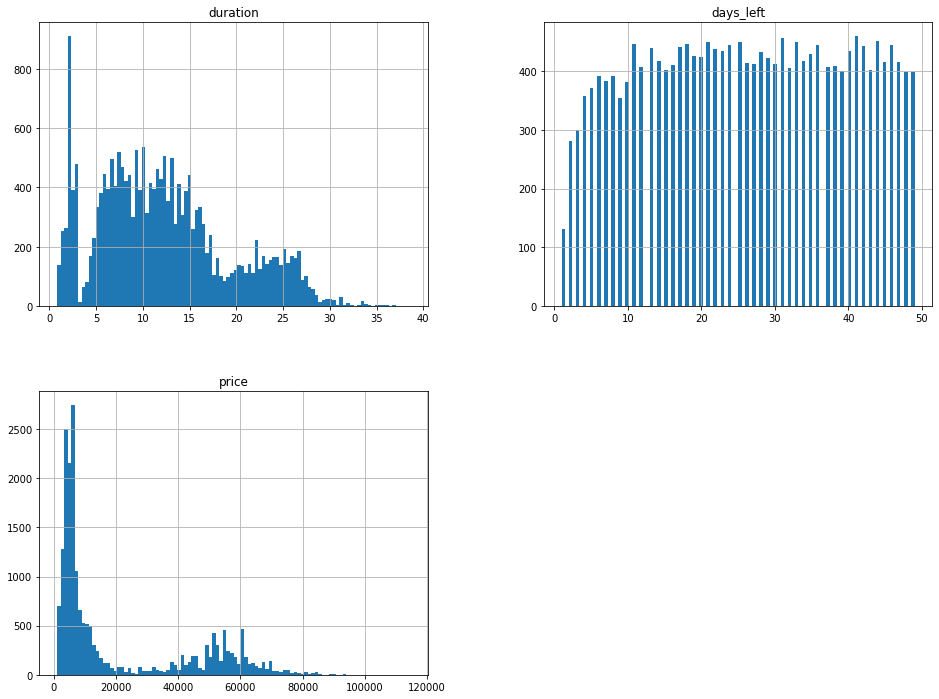

In [4]:
train_data.drop('id',axis=1).hist(bins=100, figsize=(16,12))
plt.show()

In [6]:
train_data['airline'].value_counts()

Vistara      8535
Air_India    5371
Indigo       2924
GO_FIRST     1508
AirAsia      1056
SpiceJet      606
Name: airline, dtype: int64

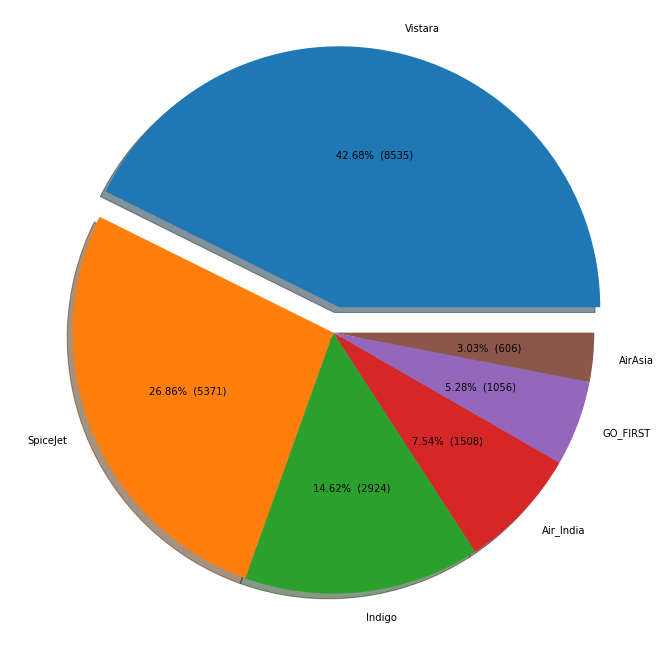

In [10]:
plt.figure(figsize=(16,12))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(list(train_data['airline'].value_counts()),
        autopct = make_autopct(list(train_data['airline'].value_counts())),
        labels=list(train_data['airline'].unique()), 
        shadow=True, 
        explode=[0.1,0,0,0,0,0])

plt.show()

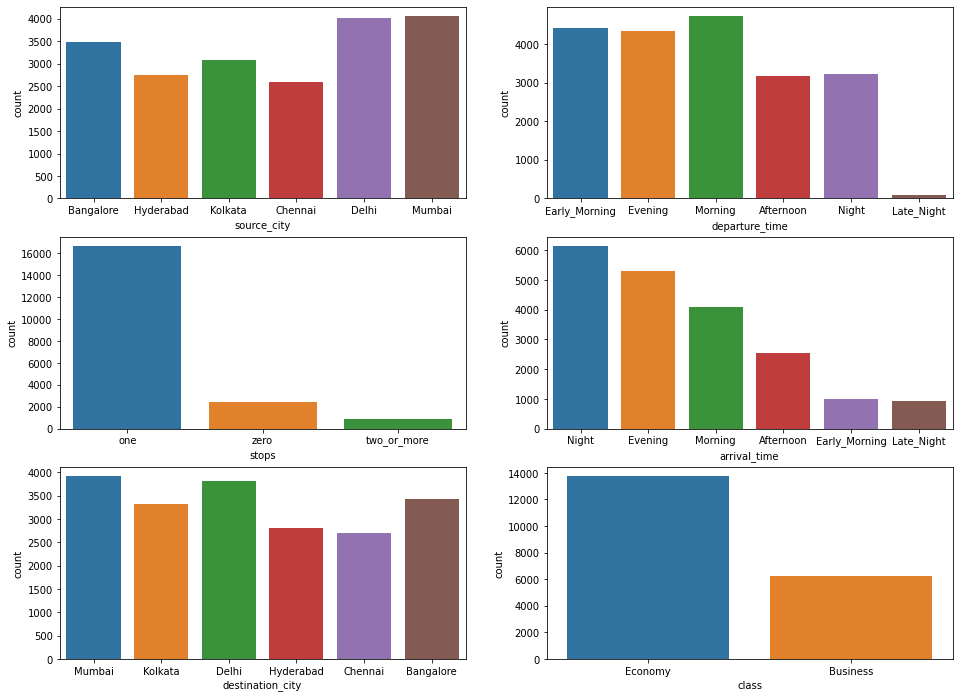

In [13]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(3,2, figsize=(16,12))

sns.countplot(ax=ax[0,0], x='source_city', data=train_data)
sns.countplot(ax=ax[0,1], x='departure_time', data=train_data)
sns.countplot(ax=ax[1,0], x='stops', data=train_data)
sns.countplot(ax=ax[1,1], x='arrival_time', data=train_data)
sns.countplot(ax=ax[2,0], x='destination_city', data=train_data)
sns.countplot(ax=ax[2,1], x='class', data=train_data)
plt.show()

In [14]:
train_data.isnull().sum()

id                  0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [15]:
#we drop unusable columns
train_data.drop(['id','flight'], axis=1, inplace=True)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   source_city       20000 non-null  object 
 2   departure_time    20000 non-null  object 
 3   stops             20000 non-null  object 
 4   arrival_time      20000 non-null  object 
 5   destination_city  20000 non-null  object 
 6   class             20000 non-null  object 
 7   duration          20000 non-null  float64
 8   days_left         20000 non-null  int64  
 9   price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.5+ MB


## Machine Learning

In [17]:
train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=42)

In [18]:
x_train = train_set.drop('price', axis=1)
x_num = x_train[['duration','days_left']]
y = train_set['price'].copy()

In [19]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attr = list(x_num)
cat_attr = ['airline','source_city','departure_time','stops','arrival_time','destination_city','class']

full_pipeline = ColumnTransformer([
                           ('num',num_pipeline,num_attr),
                           ('cat',OneHotEncoder(handle_unknown='ignore', sparse=False),cat_attr)
])

## LinearRegression

In [20]:
x_prepared = full_pipeline.fit_transform(x_train)

LR_model = LinearRegression()
LR_model.fit(x_prepared,y)

x_test = test_set.drop('price', axis=1)
y_test = test_set['price'].copy()
x_test_prepared = full_pipeline.fit_transform(x_test)
y_predict = LR_model.predict(x_test_prepared)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 4549.0
RMSE= 6721.0


## DecisionTree

In [21]:
Tree_model = DecisionTreeRegressor()
Tree_model.fit(x_prepared, y)

x_test = test_set.drop('price', axis=1)
y_test = test_set['price'].copy()
x_test_prepared = full_pipeline.fit_transform(x_test)
y_predict = Tree_model.predict(x_test_prepared)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 2296.0
RMSE= 5004.0


## RandomForest

In [24]:
RF_model = RandomForestRegressor()
RF_model.fit(x_prepared,y)

x_test = test_set.drop('price', axis=1)
y_test = test_set['price'].copy()
x_test_prepared = full_pipeline.fit_transform(x_test)
y_predict = RF_model.predict(x_test_prepared)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
print("MAE=", np.around(mae))
print("RMSE=", np.around(np.sqrt(mse)))

MAE= 1972.0
RMSE= 3799.0


## Cross-Validation usuli bilan baholash

In [32]:
X = train_data.drop('price', axis=1)
y = train_data["price"].copy()

X_prepared = full_pipeline.transform(X)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std.dev:", scores.std())

scores = cross_val_score(RF_model,X_prepared,y, scoring="neg_mean_squared_error",cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [3566.57664676 3877.33697091 4033.93274058 3480.20818866 3620.79210002
 3716.25924471 4019.50396124 3784.00168045 3723.72306932 3843.58462937]
Mean: 3766.5919232024326
Std.dev: 173.66102426203364


## Submission

In [33]:
test_data = pd.read_csv("/content/test_data.csv")
test_data.drop(['id','flight'], axis=1, inplace=True)
test_data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,Air_India,Kolkata,Evening,one,Night,Delhi,Business,28.25,2
1,Vistara,Delhi,Early_Morning,one,Night,Mumbai,Business,13.83,34
2,Air_India,Mumbai,Early_Morning,zero,Early_Morning,Chennai,Business,2.00,30
3,AirAsia,Hyderabad,Night,one,Late_Night,Delhi,Economy,5.17,26
4,Air_India,Kolkata,Night,one,Afternoon,Mumbai,Economy,16.33,35


In [35]:
test_data_prep = full_pipeline.fit_transform(test_data)

In [36]:
sub_predicted = RF_model.predict(test_data_prep)

In [37]:
samp_sol = pd.read_csv("/content/sample_solution.csv")
samp_sol.head()

,id,price
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [39]:
samp_sol['price']=sub_predicted

In [42]:
samp_sol.head(10)

,id,price
0,1,53242.6900
1,2,52829.3200
2,3,22581.0200
3,4,3042.2700
4,5,5943.1700
5,6,6467.5400
6,7,4470.1205
7,8,14127.2300
8,9,4762.0100
9,10,16894.9300


In [41]:
samp_sol.to_csv("Submission.csv")